In [18]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import pickle
from flask import Flask, request, jsonify
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Load the dataset
df = pd.read_csv('combined_data.csv')

In [20]:
# Extract relevant features
features = ['temperature', 'wind_speed', 'weather_main', 'datequery', 'dayquery', 'hourquery',
            'pressure', 'humidity', 'available_bikes']
df_features = df[features]

In [21]:
# Prepare the data
# One-hot encode the non-numerical data
encoded_data = pd.get_dummies(
    df, columns=['weather_main', 'name', 'datequery', 'dayquery', 'hourquery'])

"""# Split the encoded data into training and testing sets
train_data = encoded_data[:-12]
test_data = encoded_data[-12:]"""


'# Split the encoded data into training and testing sets\ntrain_data = encoded_data[:-12]\ntest_data = encoded_data[-12:]'

In [22]:
# Split the data into training and test sets
train_size = int(len(df_features) * 0.8)
train_data = df_features[:train_size]
test_data = df_features[train_size:]

In [23]:
# Train the time-series forecasting model
model = ARIMA(train_data['available_bikes'], order=(1, 1, 1))
results = model.fit()

In [24]:
# Evaluate the model performance on the test set
predictions = results.forecast(len(test_data))
mse = ((predictions - test_data['available_bikes']) ** 2).mean()

In [25]:
# Serialize the trained model object and save it to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(results, f)

In [26]:
# Build the Flask API endpoint
app = Flask(__name__)


@app.route('/predict', methods=['GET'])
def predict():
    # Deserialize the trained model object
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)

    # Get inputs from the GET request
    weather_data = [float(request.args.get('temperature')),
                    float(request.args.get('wind_speed')),
                    float(request.args.get('pressure')),
                    float(request.args.get('humidity'))]
    date_query = pd.to_datetime(request.args.get('date_query'))

    # Use the model to make predictions
    prediction = model.forecast(steps=1, exog=[weather_data])[0]

    # Return the prediction as a JSON object
    return jsonify({'bike_availability': prediction})

In [27]:
# Load the trained model object from the file
"""with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Call the predict() method on the loaded model object
start_idx = len(train_data)
end_idx = start_idx + 10  # predict the next 10 values
output = model.predict(start=start_idx, end=end_idx)

print(output)"""

"with open('model.pkl', 'rb') as f:\n    model = pickle.load(f)\n\n# Call the predict() method on the loaded model object\nstart_idx = len(train_data)\nend_idx = start_idx + 10  # predict the next 10 values\noutput = model.predict(start=start_idx, end=end_idx)\n\nprint(output)"

ConversionError: Failed to convert value(s) to axis units: array(['Clouds', 'Clouds', 'Clouds', ..., 'Clouds', 'Clouds', 'Clouds'],
      dtype=object)

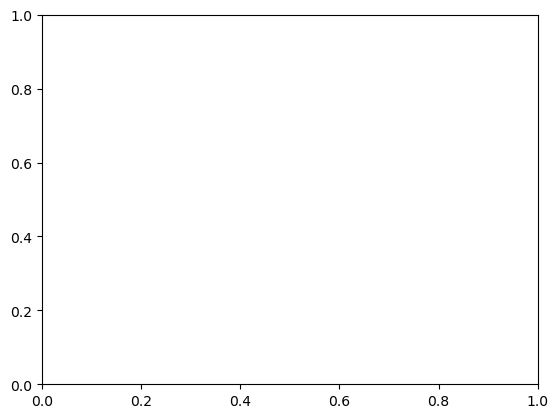

In [28]:
# Load the trained model object from the file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Call the predict() method on the loaded model object to generate forecasts
output = model.predict(start=train_data.index[0])

# Convert the pandas Series object to a pandas DataFrame
df_output = pd.DataFrame(output, columns=['predicted_mean'])

# Plot the forecasted values against the actual values
plt.plot(train_data.index, train_data.values, label='Actual')
plt.plot(df_output.index, df_output['predicted_mean'], label='Predicted')
plt.legend()
plt.show()

In [ ]:
print(train_data.index)

RangeIndex(start=0, stop=13650, step=1)


In [ ]:
# Define the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler object on your data
scaler.fit(train_data)

# Load the trained model object from the file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Call the predict() method on the loaded model object to generate forecasts
output = model.predict(start=train_data.index[0], end='2023-12-31')

# Convert the pandas Series object to a pandas DataFrame
df_output = pd.DataFrame(output, columns=['predicted_mean'])

# Inverse transform the predicted values to get them back to their original scale
predicted_values = scaler.inverse_transform(df_output)

# Convert the numpy array to a pandas DataFrame and set the index
df_predicted = pd.DataFrame(
    predicted_values, index=df_output.index, columns=['predicted_mean'])

# Print the forecasted values
print(df_predicted)

ValueError: could not convert string to float: 'Clouds'